In [179]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import time

In [180]:
# Sliding Goertzel
@jit
def sg_v2(x, k=25*4):
    Pxx = []
    N = 64*4
    w = 2*np.pi*k/N;
    cw = np.cos(w);
    c = 2*cw;
    sw = np.sin(w);
    z1=0;
    z2=0;
    #while (idx < (len(x)-1)):
    for idx in range(len(x)):
        if idx<N:
            z0 = x[idx] + c*z1 - z2;
        else:
            z0 = x[idx] - x[idx-N] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        P = z2*z2 + z1*z1 - c * z1*z2
        Pxx.append(P)
    return np.array(Pxx)

In [181]:
# Sliding Goertzel block
@jit
def sg_block(x, offset, z1, z2, Pxx, c, block_size=64, k=25*4, window_size=64*4):
    #Pxx = np.zeros[block_size]
    #w = 2*np.pi*k/window_size;
    #c = 2*np.cos(w);
    for idx in range(block_size):
        z0 = x[offset + idx] - x[offset + idx-window_size] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        Pxx[idx] = z2*z2 + z1*z1 - c * z1*z2
    return z1, z2

In [182]:
raw = np.fromfile('single_tone_v2.dat', dtype=np.int32)
data = raw>>14

In [183]:
%timeit filtered = sg_v2(data, k=100)

6.91 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [184]:
fd = open('single_tone_v2.dat', 'rb')
raw = fd.read()
fd.close()

count = 0
z1, z2 = 0, 0
ring = np.zeros(512, np.int32)
write_addr = 0
result = np.zeros(1280000)
Pxx = np.zeros(64)
k=100; window_size=256
w = 2*np.pi*k/window_size;
c = 2*np.cos(w);

start = time.time()
for count in range(20000):
    block = np.frombuffer(raw[(count*256):((count+1)*256)], dtype=np.int32)
    block = block >> 14
    if (len(block)==0):
        break
    ring[(write_addr):(write_addr+64)] = block
    z1, z2 = sg_block(ring, write_addr, z1, z2, Pxx, c)
    write_addr += 64
    write_addr &= (512-1)
    result[count*64:(count+1)*64] = Pxx
print(time.time()-start)

3.738917112350464


<IPython.core.display.Javascript object>


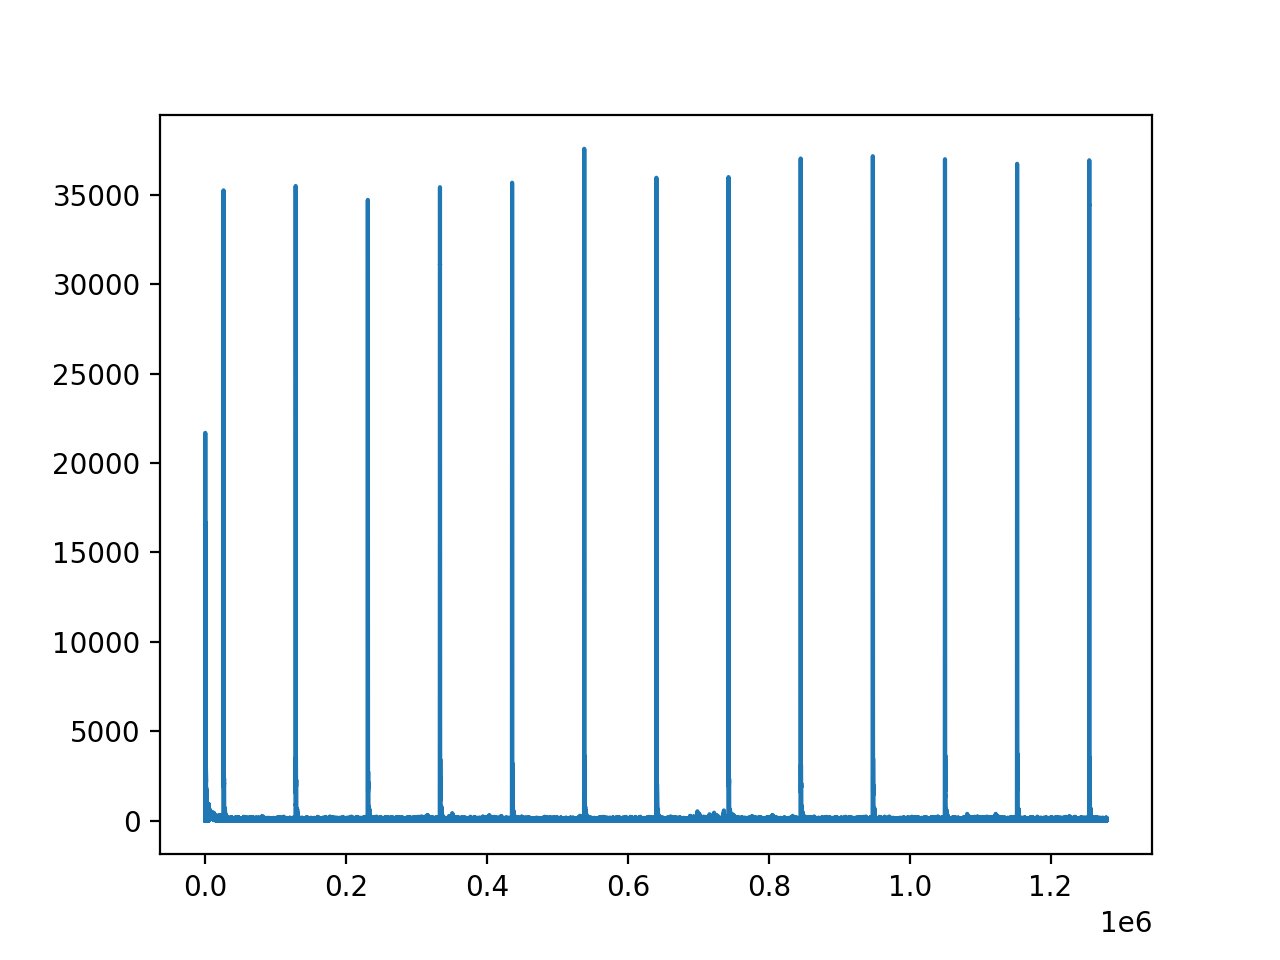

In [188]:
plt.figure()
plt.plot((2*result)**0.5)

In [176]:
result

array([   0.        ,    0.        ,    0.        , ..., 1460.22290834,
       3857.33151994, 2361.90384801])

In [177]:
result - filtered

array([0., 0., 0., ..., 0., 0., 0.])

In [173]:
3/20000

0.00015

In [155]:
%timeit sg_block(ring, write_addr, z1, z2, Pxx)

97.5 µs ± 3.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
